In [1]:
#from veneer.manage import create_command_line

#import veneer-py

from veneer.manage import start, create_command_line, kill_all_now
import veneer
import geopandas
import pandas as pd

In [6]:
#veneer_install = 'D:/PythonScriptingForGBR/VeneerPlugin/v411'
#source_version = '4.1.1'
veneer_install = 'C:/Program Files/eWater/Source 4.5.0.7552/Plugins/CommunityPlugins'
source_version = '4.5.0'
cmd_directory = 'C:\\tempveneer\\veneer_cmd'
path = create_command_line(veneer_install,source_version,dest=cmd_directory)
path

WindowsPath('C:/tempveneer/veneer_cmd/FlowMatters.Source.VeneerCmd.exe')

In [7]:
#catchment_project='D:\\Xike\\bu\\bu_reefhydro_bo_411_noMP.rsproj'
catchment_project = "D:\\BurnettMary\\v450\\BM_RC2016_baseline_ver450_Rob.rsproj"
num_copies=1    # Important - set this to be a number ~ the number of CPU cores in your system!
first_port=9950

In [8]:
processes,ports = start(catchment_project,
                        n_instances=num_copies,
                        ports=first_port,
                        debug=True,
                        veneer_exe=path,
                        remote=False)

Starting C:\tempveneer\veneer_cmd\FlowMatters.Source.VeneerCmd.exe -p 9950 -s  "D:\BurnettMary\v450\BM_RC2016_baseline_ver450_Rob.rsproj"
[0] Loading plugins

[0] Loaded C:\Program Files\eWater\Source 4.5.0.7552\Plugins\Dynamic_SedNet.dll

[0] Loaded C:\Program Files\eWater\Source 4.5.0.7552\Plugins\GBR_DynSed_Extension.dll

[0] Loaded .\.\FlowMatters.Source.Veneer.dll

[0] Plugins loaded (3/3)

[0] Opening project file: D:\BurnettMary\v450\BM_RC2016_baseline_ver450_Rob.rsproj

ERROR[0] log4net:ERROR Failed to find configuration section 'log4net' in the application's .config file. Check your .config file for the <log4net> and <configSections> elements. The configuration section should look like: <section name="log4net" type="log4net.Config.Log4NetConfigurationSectionHandler,log4net" />

[0] Loading project

[0] Project Loaded

[0] Burnett Mary Rebuild 2014

[0] Burnett Mary Rebuild 2014

[0] [2:03:07 PM] Veneer, by Flow Matters: http://www.flowmatters.com.au

[0] [2:03:07 PM] Started S

In [9]:
vs = [veneer.Veneer(port=p) for p in ports]

In [10]:
#kill_all_now(processes)

In [11]:
%matplotlib inline
v = vs[0]
#v.network().as_dataframe().plot()

In [12]:
sDate = v.model.get('scenario.CurrentConfiguration.StartDate')
print(sDate)

eDate = v.model.get('scenario.CurrentConfiguration.EndDate')
print(eDate)

#v.run_model()

1/07/1986 12:00:00 AM
30/06/2014 12:00:00 AM


In [13]:
the_network = v.network()
outlets = the_network.outlet_nodes()
#outlets

In [14]:
def processLinks(the_network, gaugeList, linkregs, currentLink, currentReg):
    
    theLinkName = currentLink['properties']['name']
    
    ## check if this link is a reporting point
    if theLinkName in gaugeList:
        currentReg = theLinkName
        print("Found this (link) network element: " + theLinkName)
    
    ## update the dictionary
    linkregs[theLinkName] = currentReg
    
    #print("Link info: " + str(currentLink))
    
    fNodeID = currentLink['properties']['from_node']
    
    #print("Node info: " + fNodeID)
    
    fNode = the_network['features'].find_by_id(fNodeID)
    #print(fNode)
    
    fNodeName = fNode[0]['properties']['name']
    #print(fNodeName)
    
    ## check if this link is a reporting point
    if fNodeName in gaugeList:
        currentReg = fNodeName
        print("Found this (node) network element: " + fNodeName)
    
    ## recurse
    #print(the_network.upstream_links(fNode[0]))
    for upLink in the_network.upstream_links(fNode[0]):
        #tNodeID = upLink['properties']['to_node']
        #tNode = the_network['features'].find_by_id(tNodeID)
        #print("Now processing: " + upLink['properties']['name'] + " upstream of " + tNode[0]['properties']['name'] + " with initial Region: " + currentReg)
        processLinks(the_network, gaugeList, linkregs, upLink, currentReg)

    return

In [15]:
noRegStr = 'NoReg'
#gaugeList = ['120219A','120206A','link for catchment SC #139']
#gaugeList = ['120205A','120206A','120207A','120209A','120212A','120213A','120214A','120219A']
gaugeList = ['Outlet Node6','Outlet Node37','Outlet Node12','Outlet Node13','Outlet Node18','Outlet Node20','Outlet Node24','Outlet Node14','Outlet Node43','Outlet Node55','Outlet Node19','Node on catchment SC #12','Node on catchment SC #72','Node on catchment SC #73','Node on catchment SC #469','138014A','Node on catchment SC #467','136002D','138007A']

# will assign regions to links, pair with subcatchs late
all_links = the_network['features'].find_by_feature_type('link')
linkregs = {}

## Populate the dictionary of relationships first
for link in all_links:
    linkregs[link['properties']['name']] = noRegStr

## now process the network
for outNode in outlets:
    curReg = noRegStr
    
    #print(outNode.keys())
    #print(outNode['properties'].keys())
    #print(outNode['properties']['name'])
    
    thisNodeName = outNode['properties']['name']
    
    if thisNodeName in gaugeList:
        print("Found this network element: " + thisNodeName)
        ##Set the curReg
        curReg = thisNodeName
    #else:
    #    print (thisNodeName + " was not in the list")
    
    
    ## now we begin processing
    for upLink in the_network.upstream_links(outNode):
        processLinks(the_network, gaugeList, linkregs, upLink, curReg)
    

Found this network element: Outlet Node6
Found this (node) network element: Node on catchment SC #12
Found this network element: Outlet Node12
Found this (node) network element: Node on catchment SC #72
Found this (node) network element: Node on catchment SC #73
Found this (node) network element: 136002D
Found this network element: Outlet Node13
Found this network element: Outlet Node14
Found this network element: Outlet Node18
Found this network element: Outlet Node19
Found this network element: Outlet Node24
Found this (node) network element: Node on catchment SC #467
Found this (node) network element: Node on catchment SC #469
Found this (node) network element: 138014A
Found this (node) network element: 138007A
Found this network element: Outlet Node37
Found this network element: Outlet Node43
Found this network element: Outlet Node55


In [16]:
linkregs_df = pd.DataFrame(list(linkregs.items()), columns=['LinkName','RegName'])
linkregs_df
#help(v.network)
#help(run_results2)

,LinkName,RegName
0,link for catchment SC #302,136002D
1,link for catchment SC #119,136002D
2,link for catchment SC #56,NoReg
3,link for catchment SC #485,138014A
4,Link #80,NoReg
5,link for catchment SC #39,NoReg
6,link for catchment SC #9,NoReg
7,link for catchment SC #540,138014A
8,link for catchment SC #239,136002D
9,link for catchment SC #542,138014A


In [17]:
network_df = v.network().as_dataframe()
catchdf = network_df[network_df.feature_type=='catchment']
linkdf = network_df[network_df.feature_type=='link']

#catchlinkdf = pd.merge(catchdf, linkdf, how='inner', left_on=['link'], right_on=['id'])
#'left' to try to not include those links that have no associated catchment
catchlinkdf = pd.merge(catchdf, linkdf, how='left', left_on=['link'], right_on=['id'])
catchlinkdf = catchlinkdf.rename(columns={'areaInSquareMeters_y':'linkarea', 'areaInSquareMeters_x':'areaInSquareMeters', 'feature_type_y':'link_feat_type', 'feature_type_x':'feature_type', 'geometry_y':'link_geom', 'geometry_x':'geometry', 'name_y': 'link_name'})

catchlinkdfregdf = pd.merge(catchlinkdf, linkregs_df, how='inner', left_on=['link_name'], right_on=['LinkName'])
catchlinkdfregdf = catchlinkdfregdf.rename(columns={'name_x':'subcat'})
catchlinkdfregdf.head(8)

,areaInSquareMeters,feature_type,from_node_x,geometry,icon_x,length_x,link_x,subcat,to_node_x,id_x,...,from_node_y,link_geom,icon_y,length_y,link_y,link_name,to_node_y,id_y,LinkName,RegName
0,16189200.0,catchment,NaN,"(POLYGON ((1971719 -3000700, 1971929 -3000700,...",NaN,NaN,/network/link/608,SC #609,NaN,/network/catchments/2092,...,/network/nodes/662,"LINESTRING (1971134 -3005245, 1969364 -3003325)",NaN,6782.863633,NaN,link for catchment SC #609,/network/nodes/162,/network/link/608,link for catchment SC #609,136002D
1,3652200.0,catchment,NaN,"(POLYGON ((1956749 -2955910, 1956749 -2956000,...",NaN,NaN,/network/link/607,SC #608,NaN,/network/catchments/2101,...,/network/nodes/142,"LINESTRING (1957334 -2957455, 1956734 -2955865)",NaN,1808.528137,NaN,link for catchment SC #608,/network/nodes/141,/network/link/607,link for catchment SC #608,136002D
2,3598200.0,catchment,NaN,"(POLYGON ((1956149 -2933950, 1956209 -2933950,...",NaN,NaN,/network/link/606,SC #607,NaN,/network/catchments/2110,...,/network/nodes/136,"LINESTRING (1956674 -2935345, 1956494 -2933935)",NaN,1504.264069,NaN,link for catchment SC #607,/network/nodes/135,/network/link/606,link for catchment SC #607,136002D
3,13734900.0,catchment,NaN,"(POLYGON ((1944899 -2913310, 1944929 -2913310,...",NaN,NaN,/network/link/605,SC #606,NaN,/network/catchments/2119,...,/network/nodes/131,"LINESTRING (1943954 -2916745, 1944554 -2913325)",NaN,3638.528137,NaN,link for catchment SC #606,/network/nodes/130,/network/link/605,link for catchment SC #606,136002D
4,623700.0,catchment,NaN,"(POLYGON ((1981409 -2889340, 1981499 -2889340,...",NaN,NaN,/network/link/604,SC #605,NaN,/network/catchments/2128,...,/network/nodes/661,"LINESTRING (1981364 -2889565, 1981814 -2890075)",NaN,713.969696,NaN,link for catchment SC #605,/network/nodes/118,/network/link/604,link for catchment SC #605,Node on catchment SC #73
5,12663900.0,catchment,NaN,"(POLYGON ((1976159 -2899030, 1976159 -2899060,...",NaN,NaN,/network/link/603,SC #604,NaN,/network/catchments/2137,...,/network/nodes/107,"LINESTRING (1979714 -2901205, 1980254 -2900245)",NaN,1346.101731,NaN,link for catchment SC #604,/network/nodes/106,/network/link/603,link for catchment SC #604,Node on catchment SC #73
6,13335300.0,catchment,NaN,"(POLYGON ((1983359 -2873170, 1983419 -2873170,...",NaN,NaN,/network/link/602,SC #603,NaN,/network/catchments/2146,...,/network/nodes/101,"LINESTRING (1983794 -2876635, 1983644 -2873155)",NaN,3611.543289,NaN,link for catchment SC #603,/network/nodes/100,/network/link/602,link for catchment SC #603,Node on catchment SC #73
7,1200600.0,catchment,NaN,"(POLYGON ((1950419 -2823580, 1950449 -2823580,...",NaN,NaN,/network/link/601,SC #602,NaN,/network/catchments/2155,...,/network/nodes/69,"LINESTRING (1950254 -2824255, 1951394 -2824615)",NaN,1308.822510,NaN,link for catchment SC #602,/network/nodes/68,/network/link/601,link for catchment SC #602,NoReg


In [18]:
cols_to_keep = ['subcat', 'LinkName', 'RegName']


catchlinkdfregdf[cols_to_keep].to_csv('D:/BurnettMary/v450/contribCatchs.csv', index=False)

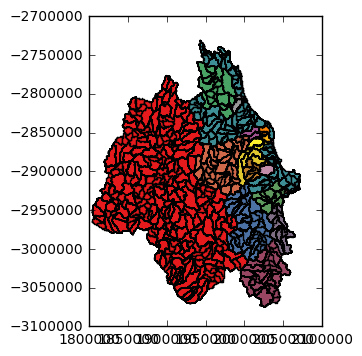

In [19]:
catchlinkdfregdf.plot(column='RegName')

In [20]:
kill_all_now(processes)